<a href="https://colab.research.google.com/github/dhcryan/kaggle_challenge_/blob/main/donghun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Store Sales - Time Series Forecasting**

 * For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

 * you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq '/content/drive/MyDrive/store-sales-time-series-forecasting.zip'

In [3]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from xgboost import XGBClassifier
from xgboost import  XGBRegressor

cpu


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import seaborn as sns
import calendar
import datetime

In [6]:
path='/content/'

### Read data

index_col=0 을 통해 column 0을 인덱스로

In [205]:
df_holidays = pd.read_csv(path+'holidays_events.csv')
df_oil = pd.read_csv(path+'oil.csv')
df_stores = pd.read_csv(path+'stores.csv')
df_trans = pd.read_csv(path+'transactions.csv')

In [206]:
train=pd.read_csv(path+'train.csv',index_col=0)
test=pd.read_csv(path+'test.csv',index_col=0)

In [207]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


df_stores 말고는 date 데이터가 있는데 object로 되어 있으니 시계열로 표현하기 위해서 datetime으로 변경

In [208]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

In [213]:
train[train.date>'2013-01-01']

,date,store_nbr,family,sales,onpromotion
id,,,,,
1782,2013-01-02,1,AUTOMOTIVE,2.000,0
1783,2013-01-02,1,BABY CARE,0.000,0
1784,2013-01-02,1,BEAUTY,2.000,0
1785,2013-01-02,1,BEVERAGES,1091.000,0
1786,2013-01-02,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [209]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [173]:
df_holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [156]:
df_holidays['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

- Additional : 추가적인 휴일

- Daily oil price. Includes values during both the train and test data timeframes

**oil data 파악**

dcoilwtico가 oil price이니 이름을 바꿔보자

In [174]:
df_oil.rename(columns={'dcoilwtico':'oilprice'},inplace=True)

In [175]:
df_oil.head()

,date,oilprice
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Let's find the relationship between crude oil and grocery sales and transactions.

Text(0, 0.5, 'Oil_price')

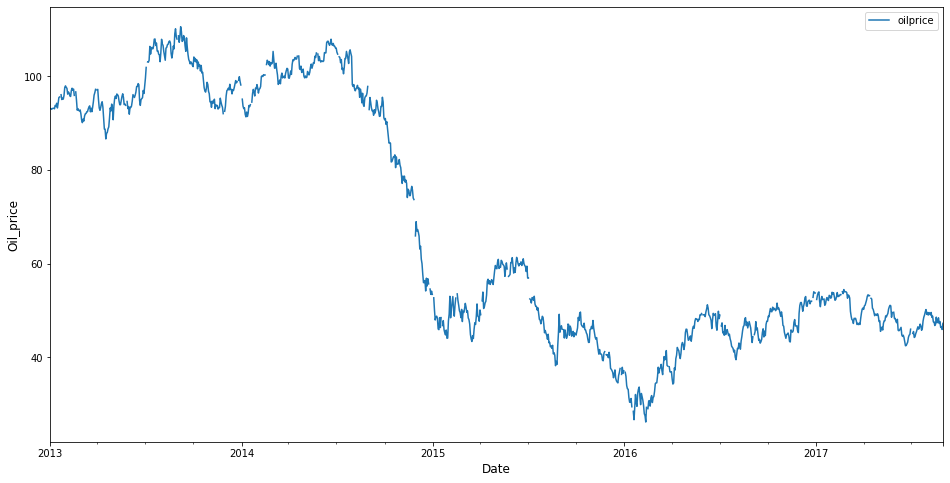

In [176]:
ax=df_oil.set_index('date').plot(figsize=(16,8))
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Oil_price',fontsize='large')

Weekly average sales

<Figure size 432x288 with 0 Axes>

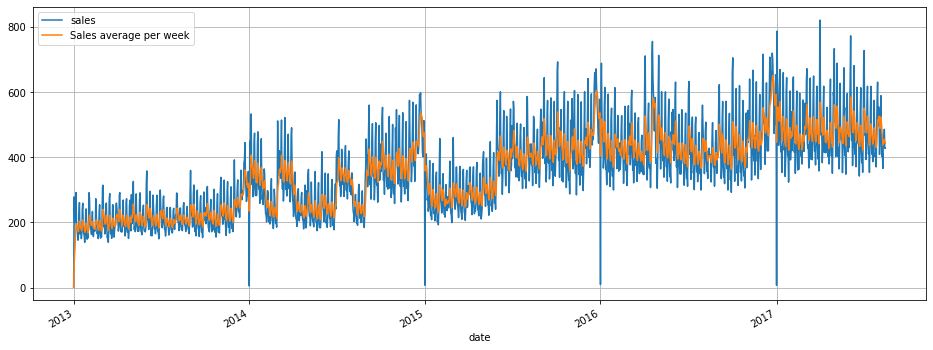

In [210]:
fig=plt.figure()
sales_mean=train.groupby('date').agg({'sales':'mean'}).reset_index()
sales_mean['Sales average per week']=sales_mean['sales'].ewm(span=7,adjust=False).mean()
ax1=sales_mean.plot(x='date',y=['sales','Sales average per week'],figsize=(16,6))
ax1.grid(True)
plt.show()

In [77]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [78]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [79]:
df_stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

In [80]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [81]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### train data 분석

In [181]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0




*   `store_nbr` : the store at which the products are sold.
*   `family` : the type of product sold.
*   `sales` : total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   `onpromotion` : total number of items in a product family that were being promoted at a store at a given date.



In [214]:
train['sales'].nunique()
train['date'].nunique() #1684

1684

In [183]:
train['onpromotion'].nunique() #362
# 제품 세일한거 362개?

362

In [215]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         3000888 non-null  datetime64[ns]
 1   store_nbr    3000888 non-null  int64         
 2   family       3000888 non-null  object        
 3   sales        3000888 non-null  float64       
 4   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [218]:
train['year']=train.date.dt.year
train['year-month']=train['date'].apply(lambda x:x.strftime('%Y-%m'))
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train

,date,store_nbr,family,sales,onpromotion,year,year-month,month,day
id,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,2013-01,1,1
1,2013-01-01,1,BABY CARE,0.000,0,2013,2013-01,1,1
2,2013-01-01,1,BEAUTY,0.000,0,2013,2013-01,1,1
3,2013-01-01,1,BEVERAGES,0.000,0,2013,2013-01,1,1
4,2013-01-01,1,BOOKS,0.000,0,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2017,2017-08,8,15
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,2017-08,8,15
3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,2017-08,8,15


In [234]:
train.to_csv('train_hun.csv')

In [219]:
train.isna().mean()

date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
year           0.0
year-month     0.0
month          0.0
day            0.0
dtype: float64

### Let's merge oil data into the train and test data (좀 이상함)

In [186]:
train=train.merge(df_oil,on='date')
test=test.merge(df_oil,on='date')

In [187]:
train=train.merge(df_holidays[['date','type','transferred']],on='date')
train=train.merge(df_stores,on='store_nbr')

In [188]:
train.isna().sum()

date               0
store_nbr          0
family             0
sales              0
onpromotion        0
oilprice       30294
type_x             0
transferred        0
city               0
state              0
type_y             0
cluster            0
dtype: int64

stores에도 type이 있고 holiday에도 type이 있어 이름 바꿔줘야 함

In [189]:
train.rename(columns={'type_x':'holiday_type','type_y':'store_type'},inplace=True)

### EDA

어떤 것들이 상점의 매출에 영향을 주는지 파악해보자

In [216]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


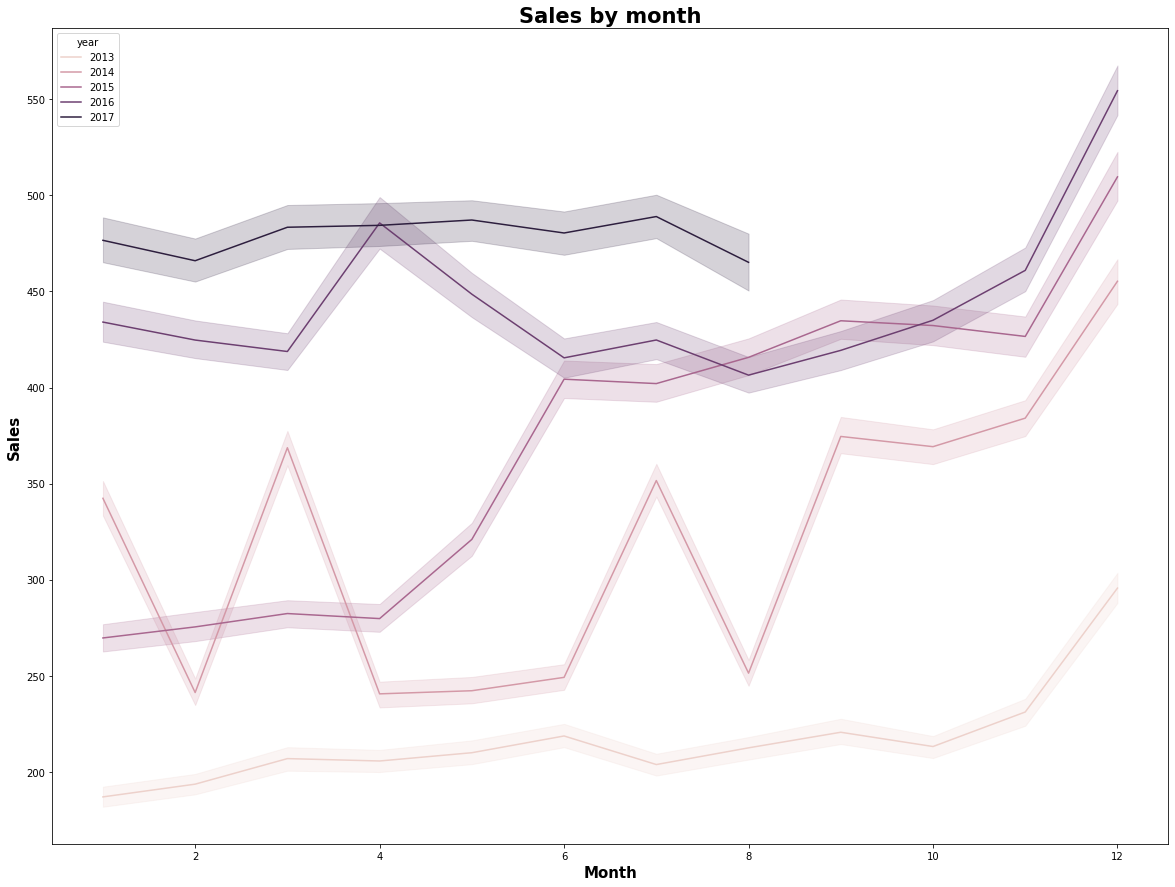

In [220]:
plt.figure(figsize=(20, 15)) 
sns.lineplot(train['month'], train['sales'], hue=train['year'])
plt.title('Sales by month', fontsize = 21, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 15, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
plt.show()

연-월 별로 분석해보자

In [221]:
year_month_df=pd.DataFrame(train.groupby('year-month').sum()['sales'])
year_month_df.head()

,sales
year-month,
2013-01,1.032762e+07
2013-02,9.658960e+06
2013-03,1.142850e+07
2013-04,1.099346e+07
2013-05,1.159770e+07


[]

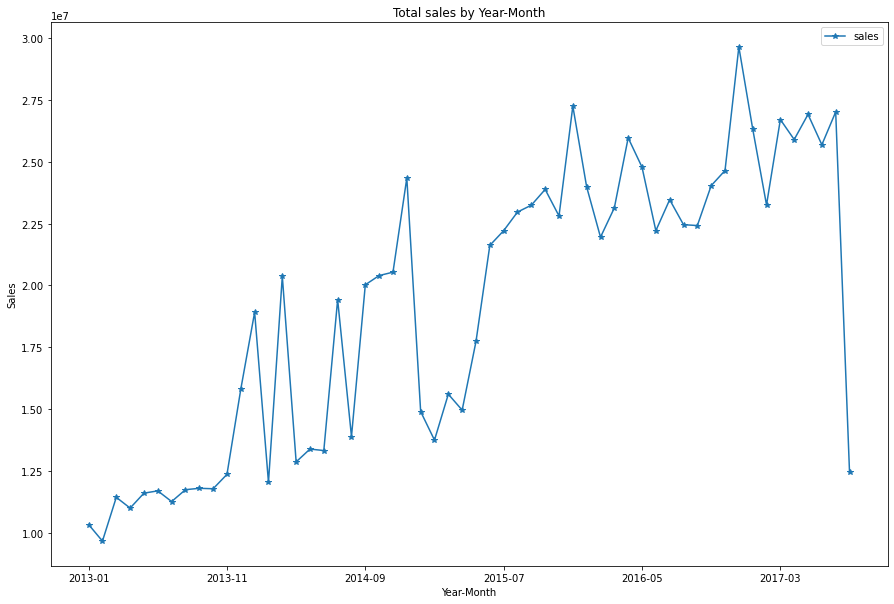

In [222]:
year_month_df.plot(kind='line',figsize=(15,10),marker='*')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Total sales by Year-Month')
plt.plot()

연말에 판매량이 증가

시계열 groupby를 통해 multi-level index로 만들 필요성

rolling mean?

In [223]:
train_cp=train.copy()
train_cp=train_cp.set_index('date')
train_cp

,store_nbr,family,sales,onpromotion,year,year-month,month,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,2013,2013-01,1,1
2013-01-01,1,BABY CARE,0.000,0,2013,2013-01,1,1
2013-01-01,1,BEAUTY,0.000,0,2013,2013-01,1,1
2013-01-01,1,BEVERAGES,0.000,0,2013,2013-01,1,1
2013-01-01,1,BOOKS,0.000,0,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,2017,2017-08,8,15
2017-08-15,9,PREPARED FOODS,154.553,1,2017,2017-08,8,15
2017-08-15,9,PRODUCE,2419.729,148,2017,2017-08,8,15


**일, 주, 월 별 판매량 비교**

<Figure size 1400x800 with 0 Axes>

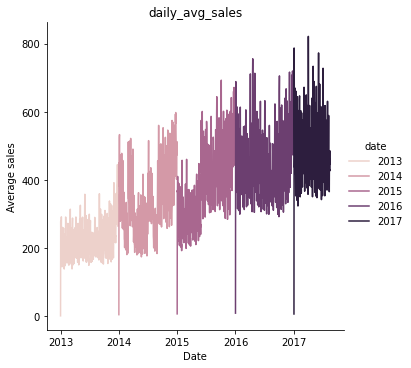

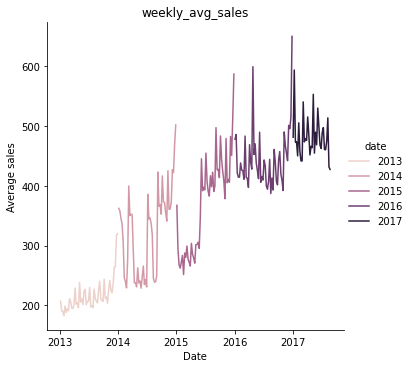

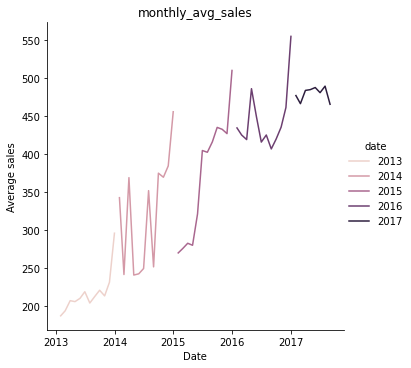

In [224]:
daily_sales=train_cp.resample('D').sales.mean().to_frame()
weekly_sales=train_cp.resample('W').sales.mean().to_frame()
monthly_sales=train_cp.resample('M').sales.mean().to_frame()
df_sales=[daily_sales,weekly_sales,monthly_sales]
titles=['daily_avg_sales','weekly_avg_sales','monthly_avg_sales']
plt.figure(figsize=(14,8),dpi=100)
for i,j in zip(df_sales,titles):
    sns.relplot(x=i.index,y=i.sales,kind='line',hue=i.index.year)
    plt.xlabel('Date')
    plt.ylabel('Average sales')
    plt.title(j)
plt.show()

연말로 갈수록 우상향

연도가 늘어날수록 우상향

연초마다 떡락하는 건 쉬는 날이라서?

### time series data analysis

In [ ]:
avg_sales=daily_sales.squeeze()
moving_avg=avg_sales.rolling(window=365,min_periods=183,center=True).mean()

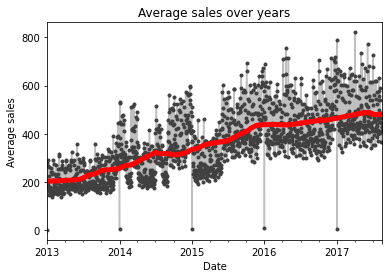

In [ ]:
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
ax=avg_sales.plot(**plot_params)
ax=moving_avg.plot(color='red',linewidth=5)
plt.xlabel('Date')
plt.ylabel('Average sales')
plt.title('Average sales over years')
plt.show()

### Trend forecast

In [ ]:
plt.style.use('seaborn-whitegrid')


### 무엇이 판매량에 영향을 주는지 파악 좀 해보자 (merge 수정해야 해서 추후에 고려)

**총판매량과 On Promotion간의 관계**

In [225]:
sales_pro=train_cp.groupby(['date'])['sales','onpromotion'].sum().reset_index() 

onpromotion : have been promoted ata a store at a given date.

In [226]:
sales_pro

,date,sales,onpromotion
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,0
2,2013-01-03,361461.231124,0
3,2013-01-04,354459.677093,0
4,2013-01-05,477350.121229,0
...,...,...,...
1679,2017-08-11,826373.722022,14179
1680,2017-08-12,792630.535079,8312
1681,2017-08-13,865639.677471,9283
1682,2017-08-14,760922.406081,8043


In [227]:
sales_pro.sort_values(by='onpromotion',ascending=False)

,date,sales,onpromotion
1433,2016-12-07,8.676537e+05,26861
1453,2016-12-28,9.515337e+05,23634
1447,2016-12-21,1.181307e+06,23427
1642,2017-07-05,8.443016e+05,23049
1460,2017-01-04,9.900935e+05,22918
...,...,...,...
307,2013-11-04,4.243142e+05,0
308,2013-11-05,3.933222e+05,0
309,2013-11-06,3.864270e+05,0
310,2013-11-07,3.462933e+05,0


이 둘 사이에 어떤 관계가 있을까 통계학적으로 접근해보자

In [228]:
plt.figure(figsize=(15,7))
corr_sales_pro=np.round(sales_pro[['sales','onpromotion']].corr().iloc[0,1],2)

<Figure size 1080x504 with 0 Axes>

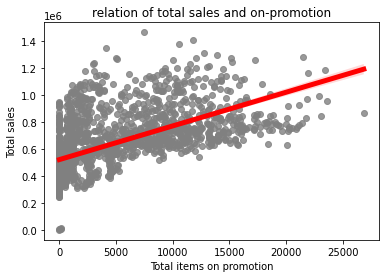

In [229]:
sns.regplot(data=sales_pro,x='onpromotion',y='sales',scatter_kws={'color':'gray'},line_kws={'color':'red','linewidth':5})
plt.xlabel('Total items on promotion')
plt.ylabel('Total sales')
plt.title('relation of total sales and on-promotion')
plt.show()

**family : 판매 제품 타입**

어떤 게 제일 잘 팔릴까?

In [43]:
sales_family=train_cp.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
sales_family

,sales
family,
GROCERY I,3926.015015
BEVERAGES,2438.183128
PRODUCE,1504.627986
CLEANING,1046.507950
DAIRY,701.256640
BREAD/BAKERY,435.797642
POULTRY,356.816725
MEATS,343.331906
PERSONAL CARE,268.421343


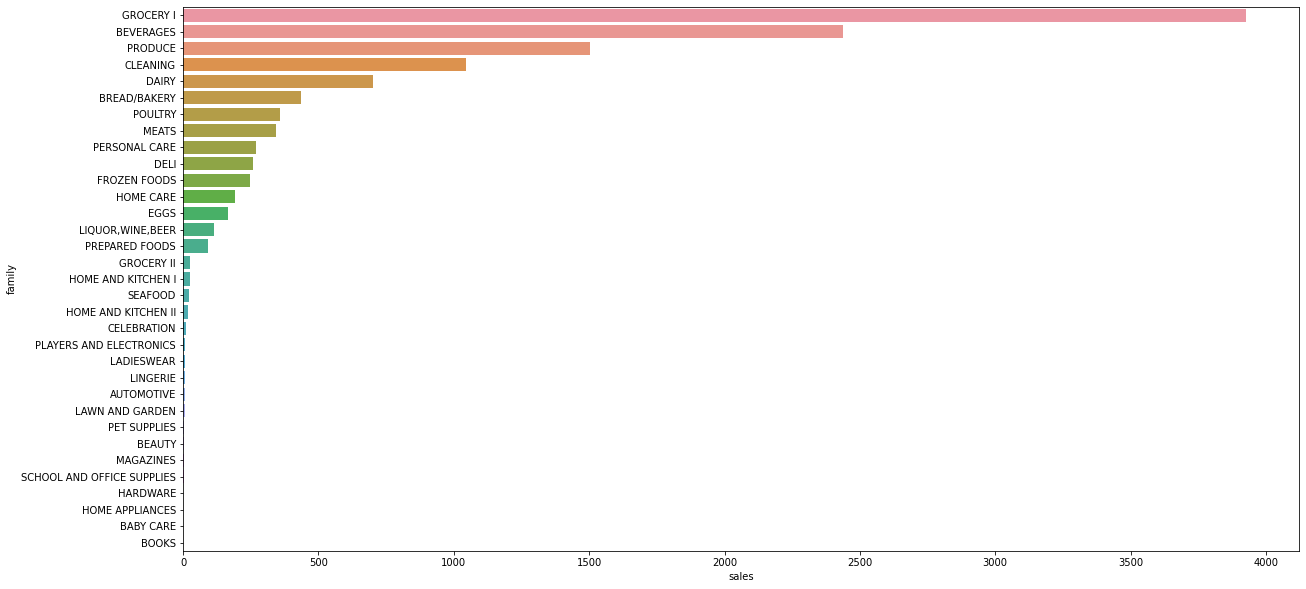

In [44]:
plt.figure(figsize=(20,10))
sns.barplot(data=sales_family,y=sales_family.index,x=sales_family.sales)
plt.show()

식료품이 제일 많이 팔리는 것을 볼 수 있음

하드웨어, 책 등은 덜 팔림

In [46]:
print('The best family products sell are: ',sales_family.index[:5])
print('\nThe worst family products sell are: ',sales_family.index[-5:])

The best family products sell are:  Index(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY'], dtype='object', name='family')

The worst family products sell are:  Index(['SCHOOL AND OFFICE SUPPLIES', 'HARDWARE', 'HOME APPLIANCES',
       'BABY CARE', 'BOOKS'],
      dtype='object', name='family')
